# 03. Gibbs Sampler for Factorization Machine

$\DeclareMathOperator*{\argmin}{arg~min}$

In [1]:
import numpy as np
from typing import Optional

## From ALS to Gibbs Sampler

Results of ordinary least squares are equivalent to the maximum a posteriori (MAP) estimation of a linear regression model with normally distributed errors.

That is, when the likelihood of $\theta$ is given by

$$
\begin{aligned}
p(y^{(d)} | \theta, x^{(d)}) &= \mathcal{N}(y^{(d)} | \theta x^{(d)}, \sigma_n^2),
\end{aligned}
$$

where $\sigma_n^2$ is the variance of the noise and its prior is uniform, the posterior distribution of $\theta$ is given by

$$
\begin{aligned}
p(\theta | y, x)
&\propto
p(y | \theta, x) p(\theta)
\\

&\propto
\prod_{d=1}^D \mathcal{N}(y^{(d)} | \theta x^{(d)}, \sigma_n^2) \times 1
\\

&\propto
\exp\left(-\frac{1}{2\sigma_n^2} \sum_{d=1}^D (y^{(d)} - \theta x^{(d)})^2\right)
\\

&=
\exp\left(-\frac{1}{2\sigma_n^2} \sum_{d=1}^D x^{(d)2} \left( \theta - \left( \sum_{d=1}^D x^{(d)2} \right)^{-1} \sum_{d=1}^D x^{(d)}y^{(d)} \right)^2 \right)
\\

&\propto
\mathcal{N}\left(\theta \middle| \mu_\theta^\star, \sigma_\theta^{\star 2} \right),
\end{aligned}
$$

where

$$
\begin{aligned}
\mu_\theta^\star
&=
\left( \sum_{d=1}^D x^{(d)2} \right)^{-1} \sum_{d=1}^D x^{(d)}y^{(d)},
\\

\sigma_\theta^{\star 2}
&=
\sigma_n^2 \left( \sum_{d=1}^D x^{(d)2} \right)^{-1}.
\end{aligned}
$$

Obviously, its MAP estimation, a.k.a. maximum likelihood estimation (MLE) --since it is equivalent to maximizing the likelihood function--,

$$
\hat \theta = \mu_\theta^\star
$$

is equivalent to the ordinary least squares solution.

In the similar way, the L2 regularized least squares is equivalent to the MAP estimation of a linear regression model with

- normal likelihood $p(y^{(d)} | \theta, x^{(d)}) \sim \mathcal{N}(y^{(d)} | \theta x^{(d)}, \sigma_n^2)$ and
- a Gaussian prior $\theta \sim \mathcal N(\theta | \mu_\theta, \sigma_\theta^2)$.

What then about sampling from the posterior distribution instead of performing MAP estimation for each parameter $\theta$ at each iteration in the ALS?

In this case, we are drawing samples from the posterior distribution of $\theta$ given $x, y$ and the other parameters $\Theta \setminus \{ \theta \}$, that is,

$$
\begin{aligned}
\tilde \theta | x, y, \Theta \setminus \{ \theta \} \sim p(\theta | x, y, \Theta \setminus \{ \theta \}) \quad \forall \theta \in \Theta.
\end{aligned}
$$

As can be seen from its expression, this posterior sampling operation is equivalent to performing **Gibbs sampling**, a type of MCMC method.

## Factorization Machine as Hierarchical Bayesian Model

Following [Rendle+ (2012)], we build a hierarchical Bayesian model for FM, which is known as the **Bayesian factorization machine** (BFM).

The hiearchical expression of the BFM is given by the graphical model below.

![alt text](figures/FM_03_hierarchical.svg)

Here,

- $\mathcal D = \{ (x^{(d)}, y^{(d)}) \}_{d=1, \dots, D}$ (denoted by $x, y$) is the dataset,
- $\Theta_M = \{ b, w, v, \lambda_n \}$ are model parameters,
- $\Theta_L = \{ \mu_w, \lambda_w, \mu_{v_k}, \lambda_{v_k} \}$ are latent parameters, and
- $\Theta_H = \{ \mu_b, \lambda_b, \mu_0, \gamma_0, \alpha_0, \beta_0, \alpha_n, \beta_n \}$ are fixed hyperparameters.

In the following, $\Theta = \Theta_M \cup \Theta_H \cup \Theta_F$ is used to simplify the notation.

### Priors

More specifically, the BFM is defined by the following generative process:

1. Dataset:

    $$
    \begin{aligned}
    p(\{ y_{\theta_i}^{(d)} \} | \{ x_{\theta_i}^{(d)} \}, \Theta, \sigma_n^2)
    &= \prod_{d=1}^D \mathcal{N} \left( y_{\theta_i}^{(d)} \middle| \theta_i x_{\theta_i}^{(d)}, \sigma_n^2 \right),
    & \theta_i &= b, w_i, v_{ik}
    \end{aligned}
    $$

2. Model parameters:

    $$
    \begin{aligned}
    p(b | \mu_b, \sigma_b^2)
    &= \mathcal{N}\left( b \middle| \mu_b, \sigma_b^2 \right),
    \\

    p(w_i | \mu_w, \sigma_w^2)
    &= \mathcal{N}\left( w_i \middle| \mu_w, \sigma_w^2 \right),
    \\

    p(v_{ik} | \mu_{v_k}, \sigma_{v_k}^2)
    &= \mathcal{N}\left( v_{ik} \middle| \mu_{v_k}, \sigma_{v_k}^2 \right),
    \\

    p(\sigma_n^2 | \alpha_n, \beta_n)
    &= \Gamma^{-1}\left( \sigma_n^2 \middle| \alpha_n, \beta_n \right),
    \end{aligned}
    $$

3. Latent parameters:

    $$
    \begin{aligned}
    p(\mu_w | \mu_0, \lambda_w, \gamma_0)
    &= \mathcal{N}\left( \mu_w \middle| \mu_0, \frac{\sigma_w^2}{\gamma_0} \right),
    \\

    p(\mu_{v_k} | \mu_0, \lambda_{v_k}, \gamma_0)
    &= \mathcal{N}\left( \mu_{v_k} \middle| \mu_0, \frac{\sigma_{v_k}^2}{\gamma_0} \right),
    \\

    p(\sigma_w^2 | \alpha_0, \beta_0)
    &= \Gamma^{-1}\left( \sigma_w^2 \middle| \alpha_0, \beta_0 \right),
    \\

    p(\sigma_{v_k}^2 | \alpha_0, \beta_0)
    &= \Gamma^{-1}\left( \sigma_{v_k}^2 \middle| \alpha_0, \beta_0 \right).
    \end{aligned}
    $$

### Conditional Posteriors

Thanks to the conjugacy of the normal and gamma distributions, the posterior distributions of the parameters are also given by normal and gamma distributions:

1. Model parameters:

    $$
    \begin{aligned}
    p(b | \mathcal D, \Theta \setminus \{ b \})
    &= \mathcal{N}\left( b \middle| \mu_b^\star, \sigma_b^{\star 2} \right),
    \\

    p(w_i | \mathcal D, \Theta \setminus \{ w_i \})
    &= \mathcal{N}\left( w_i \middle| \mu_{w_i}^\star, \sigma_{w_i}^{\star 2} \right),
    \\

    p(v_{ik} | \mathcal D, \Theta \setminus \{ v_{ik} \})
    &= \mathcal{N}\left( v_{ik} \middle| \mu_{v_{ik}}^\star, \sigma_{v_{ik}}^{\star 2} \right),
    \\
    p(\sigma_n^2 | \mathcal D, \Theta \setminus \{ \sigma_n^2 \})
    &= \Gamma^{-1}\left( \sigma_n^2 \middle| \alpha_n^\star, \beta_n^\star \right),
    \end{aligned}
    $$

    where

    $$
    \begin{aligned}
    \sigma_b^{\star 2} &= \left( \frac{1}{\sigma_n^2} + \frac{1}{\sigma_b^2} \sum_{d=1}^D 1 \right)^{-1},
    &
    \mu_b^\star &= \sigma_b^{\star 2} \left( \frac{1}{\sigma_n^2} \sum_{d=1}^D y_b^{(d)} + \frac{1}{\sigma_b^2} \mu_b \right),
    \\

    \sigma_{w_i}^{\star 2} &= \left( \frac{1}{\sigma_n^2} + \frac{1}{\sigma_w^2} \sum_{d=1}^D x_{w_i}^{(d)2} \right)^{-1},
    &
    \mu_{w_i}^\star &= \sigma_{w_i}^{\star 2} \left( \frac{1}{\sigma_n^2} \sum_{d=1}^D y_{w_i}^{(d)} x_{w_i}^{(d)} + \frac{1}{\sigma_w^2} \mu_w \right),
    \\

    \sigma_{v_{ik}}^{\star 2} &= \left( \frac{1}{\sigma_n^2} + \frac{1}{\sigma_{v_k}^2} \sum_{d=1}^D x_{v_{ik}}^{(d)2} \right)^{-1},
    &
    \mu_{v_{ik}}^\star &= \sigma_{v_{ik}}^{\star 2} \left( \frac{1}{\sigma_n^2} \sum_{d=1}^D y_{v_{ik}}^{(d)} x_{v_{ik}}^{(d)} + \frac{1}{\sigma_{v_k}^2} \mu_{v_k} \right),
    \\

    \alpha_n^\star &= \alpha_n + \frac{D}{2},
    &
    \beta_n^\star &= \beta_n + \frac{1}{2} \sum_{d=1}^D \left( y_b^{(d)} - \theta x_\theta^{(d)} \right)^2.
    \end{aligned}
    $$

2. Latent parameters:

    $$
    \begin{aligned}
    p(\mu_w | \Theta \setminus \{ \mu_w \})
    &= \mathcal{N}\left( \mu_w \middle| \mu_{\mu_w}^\star, \frac{\sigma_0^{2}}{\gamma_{\mu_w}^\star} \right),
    &
    p(\sigma_w^2 | \Theta \setminus \{ \sigma_w^2\})
    &= \Gamma^{-1}\left( \sigma_w^2 \middle| \alpha_{w}^\star, \beta_{w}^\star \right),
    \\

    p(\mu_{v_k} | \Theta \setminus \{ \mu_{v_k} \})
    &= \mathcal{N}\left( \mu_{v_k} \middle| \mu_{\mu_{v_k}}^\star, \frac{\sigma_0^{2}}{\gamma_{\mu_{v_k}}^\star} \right),
    &
    p(\sigma_{v_k}^2 | \Theta \setminus \{ \sigma_{v_k}^2\})
    &= \Gamma^{-1}\left( \sigma_{v_k}^2 \middle| \alpha_{v_{ik}}^\star, \beta_{v_{ik}}^\star \right).
    \end{aligned}
    $$

    where

    $$
    \begin{aligned}
    \mu_{\mu_w}^\star &= \frac{1}{\gamma_{\mu_w}^\star} \left( \sum_{i=1}^N w_i + \gamma_0 \mu_0 \right),
    &
    \gamma_{\mu_w}^\star &= \gamma_0 + N,
    \\

    \mu_{\mu_{v_k}}^\star &= \frac{1}{\gamma_{\mu_{v_k}}^\star} \left( \sum_{i=1}^N v_{ik} + \gamma_0 \mu_0 \right),
    &
    \gamma_{\mu_{v_k}}^\star &= \gamma_0 + N,
    \\

    \alpha_{w_i}^\star &= \alpha_{w} + \frac{N + 1}{2},
    &
    \beta_{w_i}^\star &= \beta_{w} + \frac{1}{2} \left( \sum_{d=1}^D \left( w_i - \mu_w \right)^2 + \gamma_0 \left( \mu_w - \mu_0 \right)^2 \right),
    \\

    \alpha_{v_{ik}}^\star &= \alpha_{v_k} + \frac{N + 1}{2},
    &
    \beta_{v_{ik}}^\star &= \beta_{v_k} + \frac{1}{2} \left( \sum_{d=1}^D \left( v_{ik} - \mu_{v_k} \right)^2 + \gamma_0 \left( \mu_{v_k} - \mu_0 \right)^2 \right).
    \end{aligned}
    $$

If we write $\theta = b, w, v_k$, the above equations can be written in a more compact form:

$$
\begin{aligned}

p(\theta_i | \mathcal D, \Theta \setminus \{ \theta_i \})
&= \mathcal{N}\left( \theta_i \middle| \mu_{\theta_i}^\star, \sigma_{\theta_i}^{\star 2} \right),
\\

p(\mu_\theta | \Theta \setminus \{ \mu_\theta \})
&= \mathcal{N}\left( \mu_\theta \middle| \mu_{\mu_\theta}^\star, \frac{\sigma_0^{2}}{\gamma_{\mu_\theta}^\star} \right),
\\

p(\sigma_\theta^2 | \Theta \setminus \{ \sigma_\theta^2\})
&= \Gamma^{-1}\left( \sigma_\theta^2 \middle| \alpha_{\theta}^\star, \beta_{\theta}^\star \right),
\\

p(\sigma_n^2 | \mathcal D, \Theta \setminus \{ \sigma_n^2 \})
&= \Gamma^{-1}\left( \sigma_n^2 \middle| \alpha_n^\star, \beta_n^\star \right).
\end{aligned}
$$

where

$$
\begin{aligned}
\mu_{\theta_i}^\star &= \sigma_{\theta_i}^{\star 2} \left( \frac{1}{\sigma_n^2} \sum_{d=1}^D y_{\theta_i}^{(d)} x_{\theta_i}^{(d)} + \frac{1}{\sigma_\theta^2} \mu_\theta \right),
&
\sigma_{\theta_i}^{\star 2} &= \left( \frac{1}{\sigma_n^2} + \frac{1}{\sigma_\theta^2} \sum_{d=1}^D x_{\theta_i}^{(d)2} \right)^{-1},
\\

\mu_{\mu_\theta}^\star &= \frac{1}{\gamma_{\mu_\theta}^\star} \left( \sum_{i=1}^N \theta_i + \gamma_0 \mu_0 \right),
&
\gamma_{\mu_\theta}^\star &= \gamma_0 + N,
\\

\alpha_{\theta}^\star &= \alpha_{\theta} + \frac{N + 1}{2},
&
\beta_{\theta}^\star &= \beta_{\theta} + \frac{1}{2} \left( \sum_{d=1}^D \left( \theta_i - \mu_\theta \right)^2 + \gamma_0 \left( \mu_\theta - \mu_0 \right)^2 \right).
\\

\alpha_n^\star &= \alpha_n + \frac{D}{2},
&
\beta_n^\star &= \beta_n + \frac{1}{2} \sum_{d=1}^D \left( y_b^{(d)} - \theta_i x_{\theta_i}^{(d)} \right)^2.
\end{aligned}
$$

Substituting

$$
\begin{aligned}
x_{\theta_i}^{(d)} &\coloneqq h_{\theta_i}^{(d)}, \\
y_{\theta_i}^{(d)} &\coloneqq y^{(d)} - g_{\theta_i}^{(d)} = y^{(d)} - (f^{(d)} - \theta_i h_{\theta_i}^{(d)})
\end{aligned}
$$

into the above distributions gives the Gibbs sampler algorithm for the BFM.

Note that the notation is changed from previous notebooks: $\theta_i$ is used instead of $\theta$ to denote a single parameter of the FM, and now $\theta$ means a set of parameters of the FM, i.e., $\theta = b \in \R$ or $\theta = w, v_k \in \R^N$, and $\theta_i = b, w_i, v_{ik} \in \R$.

Additional speeding up techniques are same as written in `FM_01_linear.ipynb`.

## Implementation

In [2]:
# Factorization Machine

class FactorizationMachines:
    def __init__(self,
        num_features: int,
        num_factors:  int,
        sigma_b_init: float=0.,
        sigma_w_init: float=1.,
        sigma_v_init: float=1.,
        seed: Optional[int]=None
    ) -> None:
        self.rng = np.random.default_rng(seed)
        b = self.rng.normal(0, sigma_b_init)
        w = self.rng.normal(0, sigma_w_init, num_features)
        v = self.rng.normal(0, sigma_v_init, (num_features, num_factors))
        self.params = {'b': b, 'w': w, 'v': v}

    def predict(self, x: np.ndarray) -> float:
        if x.ndim == 1:
            x = x.reshape(1, -1) # x: (d, n)
        b = self.params['b']     # b: (1)
        w = self.params['w']     # w: (d)
        v = self.params['v']     # v: (d, k)

        bias   = b
            # (1)
        linear = x[:, :] @ w[:]
            # (D, N) @ (N) = (D)
        inter  = 0.5 * np.sum((x[:, :] @ v[:, :]) ** 2 - (x[:, :] ** 2) @ (v[:, :] ** 2), axis=1)
            # (D, K) -> (D)

        result = bias + linear + inter
            # (D)

        if result.shape[0] == 1:
            return float(result[0])
        return result

In [3]:
# update rules

def calc_q_init(
    x: np.ndarray,
    v: np.ndarray
) -> np.ndarray:
    # x: (D, N)
    # v: (N, K)
    return x[:, :] @ v[:, :] # (D, K)

def calc_dq(
    i: int,
    x: np.ndarray,
    v_ik_new: float,
    v_ik_old: float,
) -> np.ndarray:
    # v_ik_new: float
    # v_ik_old: float
    # x: (D, N)
    return (v_ik_new - v_ik_old) * x[:, i] # (D)

def calc_df(
    x_theta: np.ndarray,
    param_new: float,
    param_old: float,
):
    return (param_new - param_old) * x_theta

def calc_xy_b(
    f: np.ndarray,
    b: float,
    x_data: np.ndarray,
    y_data: np.ndarray,
):
    # x_data: (D, N)
    # y_data: (D)
    x_b = np.ones(x_data.shape[0])
    y_b = y_data - (f - b * x_b)
    return x_b, y_b

def calc_xy_w(
    f: np.ndarray,
    w: np.ndarray,
    x_data: np.ndarray,
    y_data: np.ndarray,
    i: int
):
    # x_data: (D, N)
    # y_data: (D)
    x_w = x_data[:, i]
    y_w = y_data - (f - x_w * w[i])
    return x_w, y_w

def calc_xy_v(
    f: np.ndarray,
    q: np.ndarray,
    v: np.ndarray,
    x_data: np.ndarray,
    y_data: np.ndarray,
    i: int,
    k: int
):
    # x_data: (D, N)
    # y_data: (D)
    x_v = x_data[:, i] * (q[:, k] - x_data[:, i] * v[i, k])
    y_v = y_data - (f - x_v * v[i, k])
    return x_v, y_v

In [4]:
# samplers

# fixed_params = {
#     'mu_b':     0., # for b
#     'sigma2_b': 1., # for b
#     'mu_0':     0., # for w, v
#     'gamma_0':  0., # for w, v
#     'alpha_0':  1., # for w, v
#     'beta_0':   1., # for w, v
#     'alpha_n':  1., # for noise
#     'beta_n':   1., # for noise
# }

def sample_from_inverse_gamma(
    alpha: float,
    beta:  float,
    seed:  Optional[int]=None
):
    rng = np.random.default_rng(seed)
    return 1 / rng.gamma(alpha, 1 / beta)

def sample_posterior_sigma2_noise(
    x_theta_i: np.ndarray,
    y_theta_i: np.ndarray,
    theta_i:   float,
    fixed_params: dict,
    seed: Optional[int]=None
):
    # x_theta_i: (D)
    # y_theta_i: (D)
    alpha_n = fixed_params['alpha_n']
    beta_n  = fixed_params['beta_n']

    D = x_theta_i.shape[0]

    a_noise_post = alpha_n + D / 2
    b_noise_post = beta_n + np.sum( (y_theta_i - x_theta_i * theta_i)**2 ) / 2
    return sample_from_inverse_gamma(a_noise_post, b_noise_post, seed)

def sample_posterior_theta_i(
    x_theta_i: np.ndarray,
    y_theta_i: np.ndarray,
    sigma2_noise: float,
    mu_theta: float,
    sigma2_theta: float,
    seed: Optional[int]=None
):
    # x_theta: (D)
    # y_theta: (D)
    rng = np.random.default_rng(seed)
    sigma2_theta_i_post = 1 / ( np.sum(x_theta_i**2) / sigma2_noise + 1 / sigma2_theta )
    mu_theta_i_post = sigma2_theta_i_post * ( np.sum(x_theta_i * y_theta_i) / sigma2_noise + mu_theta / sigma2_theta )
    return rng.normal(mu_theta_i_post, np.sqrt(sigma2_theta_i_post))

def sample_posterior_mu_theta_and_sigma2_theta(
    theta: np.ndarray[float],
    sigma2_theta: float,
    fixed_params: dict,
    seed: Optional[int]=None
):
    # theta: (N)
    rng = np.random.default_rng(seed)

    N = theta.shape[0]

    gamma_0 = fixed_params['gamma_0']
    mu_0    = fixed_params['mu_0']
    alpha_0 = fixed_params['alpha_0']
    beta_0  = fixed_params['beta_0']

    ga_mu_theta_post = gamma_0 + N
    mu_mu_theta_post = (np.sum(theta) + gamma_0 * mu_0) / ga_mu_theta_post
    mu_theta_new  = rng.normal(mu_mu_theta_post, np.sqrt(sigma2_theta / ga_mu_theta_post))

    mu_theta = mu_theta_new

    a_theta_post = alpha_0 + (N + 1) / 2
    b_theta_post = beta_0 + 0.5 * (np.sum((theta - mu_theta)**2) + gamma_0 * (mu_theta - mu_0)**2)

    sigma2_theta_new = sample_from_inverse_gamma(a_theta_post, b_theta_post, seed)
    return mu_theta_new, sigma2_theta_new

In [5]:
# posterior sampling
def train_fm_gibbs(
    model_params: dict,
    latent_params: dict,
    fixed_params: dict,
    x_data: np.ndarray,
    y_data: np.ndarray,
    y_pred: np.ndarray,
    num_iter: int,
    seed: Optional[int]=None
):
    loss_hist = []

    N = x_data.shape[1]
    K = model_params['v'].shape[1]
    D = x_data.shape[0]

    q = calc_q_init(x_data, model_params['v'])

    for iter in range(num_iter):
        # noise parameter
        x_b, y_b = calc_xy_b(y_pred, model_params['b'], x_data, y_data)
        latent_params['sigma2_noise'] = sample_posterior_sigma2_noise(x_b, y_b, model_params['b'], fixed_params)

        # hyperparameters
        latent_params['mu_w'], latent_params['sigma2_w'] = sample_posterior_mu_theta_and_sigma2_theta(model_params['w'], latent_params['sigma2_w'], fixed_params)
        for k in range(K):
            latent_params['mu_v'][k], latent_params['sigma2_v'][k] = sample_posterior_mu_theta_and_sigma2_theta(model_params['v'][:, k], latent_params['sigma2_v'][k], fixed_params)

        # b
        x_b, y_b = calc_xy_b(y_pred, model_params['b'], x_data, y_data)
        b_new    = sample_posterior_theta_i(x_b, y_b, latent_params['sigma2_noise'], fixed_params['mu_b'], fixed_params['sigma2_b'])
        y_pred   = y_pred + calc_df(x_b, b_new, model_params['b'])
        model_params['b'] = b_new

        # w
        for i in range(N):
            x_w, y_w = calc_xy_w(y_pred, model_params['w'], x_data, y_data, i)
            w_i_new  = sample_posterior_theta_i(x_w, y_w, latent_params['sigma2_noise'], latent_params['mu_w'], latent_params['sigma2_w'])
            y_pred   = y_pred + calc_df(x_w, w_i_new, model_params['w'][i])
            model_params['w'][i] = w_i_new

        # v
            for k in range(K):
                x_v, y_v = calc_xy_v(y_pred, q, model_params['v'], x_data, y_data, i, k)
                v_ik_new = sample_posterior_theta_i(x_v, y_v, latent_params['sigma2_noise'], latent_params['mu_v'][k], latent_params['sigma2_v'][k])
                y_pred   = y_pred + calc_df(x_v, v_ik_new, model_params['v'][i, k])
                q[:,k]   = q[:,k] + calc_dq(i, x_data, v_ik_new, model_params['v'][i, k])
                model_params['v'][i, k] = v_ik_new

        if (iter+1) % 50 == 0:
            print(f'iter: {iter+1}, loss: {np.sum((y_data - y_pred) ** 2) / D}')
        loss_hist.append(np.sum((y_data - y_pred) ** 2) / D)

    return model_params, loss_hist

Now we consider trivial values for the fixed parameters $\Theta_H$:

$$
\left\{\begin{aligned}
\mu_b      &= 0, \\
\sigma_b^2 &= 1, \\
\mu_0      &= 0, \\
\lambda_0  &= 1, \\
\alpha_0   &= 1, \\
\beta_0    &= 1, \\
\alpha_n   &= 1, \\
\beta_n    &= 1.
\end{aligned}\right.
$$

In [19]:
# test
N = 16
K = 8
D = 128

seed = 0
rng  = np.random.default_rng(seed)
fm   = FactorizationMachines(N, K, seed=seed)

Q      = rng.uniform(-1., 1., (N, N))
x_data = rng.choice((0, 1), size=(D, N))
y_data = np.einsum('dn,nm,dm->d', x_data, Q, x_data)

model_params = fm.params

latent_params = {
    'mu_w': 0.,
    'mu_v': np.zeros(K, dtype=float),
    'sigma2_w': 1.,
    'sigma2_v': np.ones(K, dtype=float)
}

fixed_params = {
    'mu_b':     0., # for b
    'sigma2_b': 1., # for b
    'mu_0':     0., # for w, v
    'gamma_0':  0., # for w, v
    'alpha_0':  1., # for w, v
    'beta_0':   1., # for w, v
    'alpha_n':  1., # for noise
    'beta_n':   1., # for noise
}

_, loss_hist = train_fm_gibbs(
    model_params,
    latent_params,
    fixed_params,
    x_data,
    y_data,
    fm.predict(x_data),
    500,
)

iter: 50, loss: 0.8123035733902947
iter: 100, loss: 0.745339599312905
iter: 150, loss: 0.708606057127241
iter: 200, loss: 0.6521765242780531
iter: 250, loss: 0.769489583820566
iter: 300, loss: 0.6259527665490583
iter: 350, loss: 0.44907690926367666
iter: 400, loss: 0.7016396935676144
iter: 450, loss: 0.599885835936156
iter: 500, loss: 0.6969464034002996


Looks good. Let's implement the Gibbs sampler in Julia and see how it works.

In [7]:
from julia import Main

Main.eval("""
using Random
using Distributions

# update rules

function calc_q_init(
    x::Array{Float64,2},
    v::Array{Float64,2}
)::Array{Float64,2}
    # x: (D, N)
    # v: (N, K)
    return x * v # (D, K)
end

function calc_dq(
    i::Int,
    x::Array{Float64,2},
    v_ik_new::Float64,
    v_ik_old::Float64
)::Array{Float64,1}
    # v_ik_new: float
    # v_ik_old: float
    # x: (D, N)
    return (v_ik_new - v_ik_old) .* x[:, i] # (D)
end

function calc_df(
    x_theta::Array{Float64,1},
    param_new::Float64,
    param_old::Float64
)::Array{Float64,1}
    return (param_new - param_old) .* x_theta
end

function calc_xy_b(
    f::Array{Float64,1},
    b::Float64,
    x_data::Array{Float64,2},
    y_data::Array{Float64,1}
)::Tuple{Array{Float64,1}, Array{Float64,1}}
    # x_data: (D, N)
    # y_data: (D)
    x_b = ones(size(x_data, 1))
    y_b = y_data - (f - b .* x_b)
    return x_b, y_b
end

function calc_xy_w(
    f::Array{Float64,1},
    w::Array{Float64,1},
    x_data::Array{Float64,2},
    y_data::Array{Float64,1},
    i::Int
)::Tuple{Array{Float64,1}, Array{Float64,1}}
    # x_data: (D, N)
    # y_data: (D)
    x_w = x_data[:, i]
    y_w = y_data - (f - x_w .* w[i])
    return x_w, y_w
end

function calc_xy_v(
    f::Array{Float64,1},
    q::Array{Float64,2},
    v::Array{Float64,2},
    x_data::Array{Float64,2},
    y_data::Array{Float64,1},
    i::Int,
    k::Int
)::Tuple{Array{Float64,1}, Array{Float64,1}}
    # x_data: (D, N)
    # y_data: (D)
    x_v = x_data[:, i] .* (q[:, k] - x_data[:, i] .* v[i, k])
    y_v = y_data - (f - x_v .* v[i, k])
    return x_v, y_v
end

# samplers
function sample_from_inverse_gamma(
    alpha::Float64,
    beta::Float64,
    seed::Union{Int, Nothing}=nothing
)::Float64
    if !isnothing(seed)
        Random.seed!(seed)
    end
    return 1 / rand(Gamma(alpha, 1 / beta))
end

function sample_posterior_sigma2_noise(
    x_theta_i::Array{Float64,1},
    y_theta_i::Array{Float64,1},
    theta_i::Float64,
    fixed_params::Dict{Any, Any},
    seed::Union{Int, Nothing}=nothing
)::Float64
    # x_theta_i: (D)
    # y_theta_i: (D)
    alpha_n = fixed_params["alpha_n"]
    beta_n  = fixed_params["beta_n"]

    D = length(x_theta_i)

    a_noise_post = alpha_n + D / 2
    b_noise_post = beta_n + sum((y_theta_i - x_theta_i .* theta_i).^2) / 2
    return sample_from_inverse_gamma(a_noise_post, b_noise_post, seed)
end

function sample_posterior_theta_i(
    x_theta_i::Array{Float64,1},
    y_theta_i::Array{Float64,1},
    sigma2_noise::Float64,
    mu_theta::Float64,
    sigma2_theta::Float64,
    seed::Union{Int, Nothing}=nothing
)::Float64
    # x_theta: (D)
    # y_theta: (D)
    if !isnothing(seed)
        Random.seed!(seed)
    end
    sigma2_theta_i_post = 1 / (sum(x_theta_i.^2) / sigma2_noise + 1 / sigma2_theta)
    mu_theta_i_post = sigma2_theta_i_post * (sum(x_theta_i .* y_theta_i) / sigma2_noise + mu_theta / sigma2_theta)
    return rand(Normal(mu_theta_i_post, sqrt(sigma2_theta_i_post)))
end

function sample_posterior_mu_theta_and_sigma2_theta(
    theta::Array{Float64,1},
    sigma2_theta::Float64,
    fixed_params::Dict{Any, Any},
    seed::Union{Int, Nothing}=nothing
)::Tuple{Float64, Float64}
    # theta: (N)
    if !isnothing(seed)
        Random.seed!(seed)
    end

    N = length(theta)

    gamma_0 = fixed_params["gamma_0"]
    mu_0    = fixed_params["mu_0"]
    alpha_0 = fixed_params["alpha_0"]
    beta_0  = fixed_params["beta_0"]

    ga_mu_theta_post = gamma_0 + N
    mu_mu_theta_post = (sum(theta) + gamma_0 * mu_0) / ga_mu_theta_post
    mu_theta_new  = rand(Normal(mu_mu_theta_post, sqrt(sigma2_theta / ga_mu_theta_post)))

    mu_theta = mu_theta_new

    a_theta_post = alpha_0 + (N + 1) / 2
    b_theta_post = beta_0 + 0.5 * (sum((theta .- mu_theta).^2) + gamma_0 * (mu_theta - mu_0)^2)

    sigma2_theta_new = sample_from_inverse_gamma(a_theta_post, b_theta_post, seed)
    return mu_theta_new, sigma2_theta_new
end

# training loop
function train_fm_gibbs(
    model_params::Dict{Any, Any},
    latent_params::Dict{Any, Any},
    fixed_params::Dict{Any, Any},
    x_data::Array{Float64,2},
    y_data::Array{Float64,1},
    y_pred::Array{Float64,1},
    num_iter::Int,
    show_iter::Bool=false,
    seed::Union{Int, Nothing}=nothing
)::Tuple{Dict{Any, Any}, Array{Float64,1}}
    loss_hist = []

    N = size(x_data, 2)
    K = size(model_params["v"], 2)
    D = size(x_data, 1)

    q = calc_q_init(x_data, model_params["v"])

    for iter in 1:num_iter
        # noise parameter
        x_b, y_b = calc_xy_b(y_pred, model_params["b"], x_data, y_data)
        latent_params["sigma2_noise"] = sample_posterior_sigma2_noise(x_b, y_b, model_params["b"], fixed_params)

        # hyperparameters
        latent_params["mu_w"], latent_params["sigma2_w"] = sample_posterior_mu_theta_and_sigma2_theta(model_params["w"], latent_params["sigma2_w"], fixed_params)
        for k in 1:K
            latent_params["mu_v"][k], latent_params["sigma2_v"][k] = sample_posterior_mu_theta_and_sigma2_theta(model_params["v"][:, k], latent_params["sigma2_v"][k], fixed_params)
        end

        # b
        x_b, y_b = calc_xy_b(y_pred, model_params["b"], x_data, y_data)
        b_new    = sample_posterior_theta_i(x_b, y_b, latent_params["sigma2_noise"], fixed_params["mu_b"], fixed_params["sigma2_b"])
        y_pred   = y_pred + calc_df(x_b, b_new, model_params["b"])
        model_params["b"] = b_new

        # w
        for i in 1:N
            x_w, y_w = calc_xy_w(y_pred, model_params["w"], x_data, y_data, i)
            w_i_new  = sample_posterior_theta_i(x_w, y_w, latent_params["sigma2_noise"], latent_params["mu_w"], latent_params["sigma2_w"])
            y_pred   = y_pred + calc_df(x_w, w_i_new, model_params["w"][i])
            model_params["w"][i] = w_i_new
        end

        # v
        for i in 1:N
            for k in 1:K
                x_v, y_v = calc_xy_v(y_pred, q, model_params["v"], x_data, y_data, i, k)
                v_ik_new = sample_posterior_theta_i(x_v, y_v, latent_params["sigma2_noise"], latent_params["mu_v"][k], latent_params["sigma2_v"][k])
                y_pred   = y_pred + calc_df(x_v, v_ik_new, model_params["v"][i, k])
                q[:,k]   = q[:,k] + calc_dq(i, x_data, v_ik_new, model_params["v"][i, k])
                model_params["v"][i, k] = v_ik_new
            end
        end

        if show_iter && ((iter+1) % 50 == 0)
            println("iter: $(iter+1), loss: $(sum((y_data - y_pred) .^ 2) / D)")
        end
        push!(loss_hist, sum((y_data - y_pred) .^ 2) / D)
    end

    return model_params, loss_hist
end
""")

<PyCall.jlwrap train_fm_gibbs>

In [20]:
# test
N = 32
K = 16
D = 128

seed = 0
rng  = np.random.default_rng(seed)
fm   = FactorizationMachines(N, K, seed=seed)

Q      = rng.uniform(-1., 1., (N, N))
x_data = rng.choice((0, 1), size=(D, N))
y_data = np.einsum('dn,nm,dm->d', x_data, Q, x_data)

model_params = fm.params

latent_params = {
    'mu_w': 0.,
    'mu_v': np.zeros(K, dtype=float),
    'sigma2_w': 1.,
    'sigma2_v': np.ones(K, dtype=float)
}

fixed_params = {
    'mu_b':     0., # for b
    'sigma2_b': 1., # for b
    'mu_0':     0., # for w, v
    'gamma_0':  0., # for w, v
    'alpha_0':  1., # for w, v
    'beta_0':   1., # for w, v
    'alpha_n':  1., # for noise
    'beta_n':   1., # for noise
}

_, loss_hist = Main.train_fm_gibbs(
    model_params,
    latent_params,
    fixed_params,
    x_data.astype(float),
    y_data,
    fm.predict(x_data),
    5000,
    True
)

iter: 50, loss: 0.8831636890654417
iter: 100, loss: 0.8105320411904714
iter: 150, loss: 0.8203643884291802
iter: 200, loss: 0.602844017733315
iter: 250, loss: 1.88195197899879
iter: 300, loss: 1.3226035457585514
iter: 350, loss: 1.3847109153001609
iter: 400, loss: 0.9368725977169484
iter: 450, loss: 1.4671926031786104
iter: 500, loss: 0.8607007395254868
iter: 550, loss: 2.277400776666249
iter: 600, loss: 0.9681955653244119
iter: 650, loss: 1.536021268849749
iter: 700, loss: 0.3436211325109959
iter: 750, loss: 0.9862639651480074
iter: 800, loss: 1.3529826908129001
iter: 850, loss: 1.3157760725248258
iter: 900, loss: 2.633917154938758
iter: 950, loss: 0.620795181049483
iter: 1000, loss: 0.6410852040038362
iter: 1050, loss: 0.6035089357633553
iter: 1100, loss: 0.3433061700001981
iter: 1150, loss: 0.34036468831293576
iter: 1200, loss: 0.5474854823322661
iter: 1250, loss: 0.2108910497524487
iter: 1300, loss: 0.8723790580127269
iter: 1350, loss: 0.45577084647696403
iter: 1400, loss: 0.343955

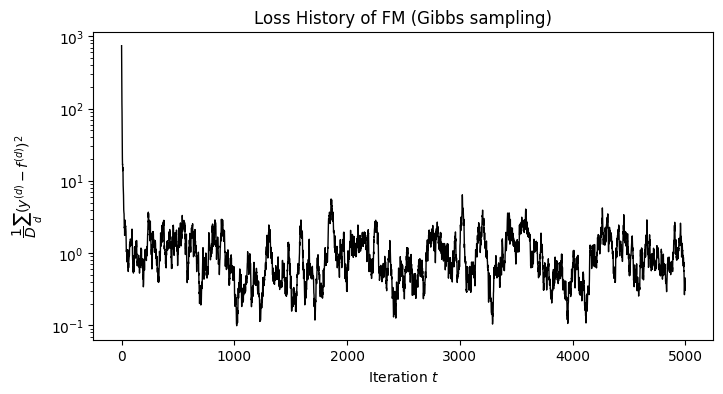

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# plt.scatter(range(len(loss_hist))[::100], loss_hist[::100], s=50, marker='o', color='none', edgecolors='black')
plt.plot(loss_hist, color='black', linewidth=1)
plt.yscale('log')
plt.xlabel(r'Iteration $t$')
plt.ylabel(r'$\dfrac{1}{D} \sum_{d} (y^{(d)} - f^{(d)})^2$')
plt.title('Loss History of FM (Gibbs sampling)')
plt.show()

The use of Gibbs sampling for learning has the advantage of automatic hyperparameter tuning capability.

Let us compare with ALS.

In [22]:
# ALS version

Main.eval("""
    function sample_param_lstsq(
        x_theta::Array{Float64},
        y_theta::Array{Float64},
        lamb::Float64=1e-8
    ) :: Float64
        return sum(x_theta .* y_theta) / (sum(x_theta .^ 2) + lamb)
    end

    function train_fm_als(
        init_params::Dict{Any, Any},
        x_data::Array{Float64},
        y_data::Array{Float64, 1},
        f_init::Array{Float64, 1},
        num_iter::Int,
        show_progress::Bool=false
    ) :: Tuple{Dict{Any, Any}, Array{Float64}}
        # get indices
        N = size(x_data, 2)
        K = size(init_params["v"], 2)

        # get initial parameter
        params = init_params

        # precalculate
        f = f_init
        q = calc_q_init(x_data, params["v"])

        # main loop
        loss_hist = Float64[]
        for iter in 1:num_iter
            # sample b
            x_b, y_b = calc_xy_b(f, params["b"], x_data, y_data)
            b_new    = sample_param_lstsq(x_b, y_b)
            f        = f + calc_df(x_b, b_new, params["b"])
            params["b"] = b_new

            # sample w
            for i in 1:N
                x_w, y_w = calc_xy_w(f, params["w"], x_data, y_data, i)
                w_i_new  = sample_param_lstsq(x_w, y_w)
                f        = f + calc_df(x_w, w_i_new, params["w"][i])
                params["w"][i] = w_i_new

                # sample v
                for k in 1:K
                    x_v, y_v = calc_xy_v(f, q, params["v"], x_data, y_data, i, k)
                    v_ik_new = sample_param_lstsq(x_v, y_v)
                    f        = f      + calc_df(x_v, v_ik_new, params["v"][i, k])
                    q[:,k]   = q[:,k] + calc_dq(i, x_data, v_ik_new, params["v"][i, k])
                    params["v"][i, k] = v_ik_new
                end
            end

            if show_progress && (iter % 100 == 0)
                println("iter: $iter, loss: $(sum((y_data - f) .^ 2) / N)")
            end

            push!(loss_hist, sum((y_data - f) .^ 2) / N)
        end

        return params, loss_hist
    end
""")

<PyCall.jlwrap train_fm_als>

In [23]:
_, loss_hist_als = Main.train_fm_als(
    model_params,
    x_data.astype(float),
    y_data,
    fm.predict(x_data),
    2500,
)

_, loss_hist_gibbs = Main.train_fm_gibbs(
    model_params,
    latent_params,
    fixed_params,
    x_data.astype(float),
    y_data,
    fm.predict(x_data),
    2500,
)

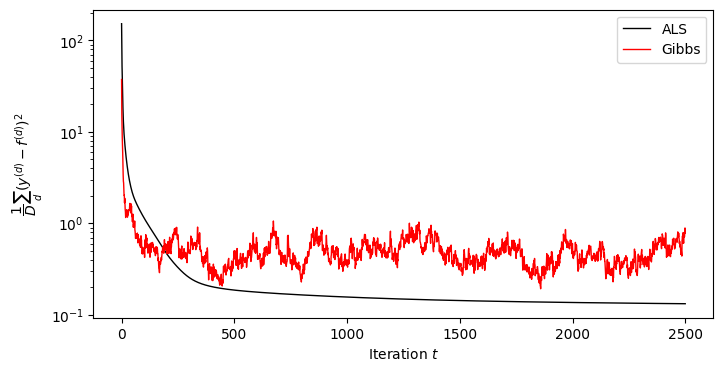

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(loss_hist_als, color='black', linewidth=1, label='ALS')
plt.plot(loss_hist_gibbs, color='red', linewidth=1, label='Gibbs')
plt.yscale('log')
plt.xlabel(r'Iteration $t$')
plt.ylabel(r'$\dfrac{1}{D} \sum_{d} (y^{(d)} - f^{(d)})^2$')
plt.legend()
plt.show()

The MSE error in the Gibbs sampler converges to a relaively larger value than that in ALS.

This value gets smaller as the number of data points increases. Let's see how it works.

In [30]:
D_list = [16, 32, 64, 128, 256]
N = 16
K = 8

seed = 0
rng  = np.random.default_rng(seed)
fm   = FactorizationMachines(N, K, seed=seed)

V = rng.uniform(-1., 1., (N, K))
Q = V @ V.T

loss_hist_list = []
for D in D_list:
    x_data = rng.choice((0, 1), size=(D, N))
    y_data = np.einsum('dn,nm,dm->d', x_data, Q, x_data)

    model_params = fm.params

    latent_params = {
        'mu_w': 0.,
        'mu_v': np.zeros(K, dtype=float),
        'sigma2_w': 1.,
        'sigma2_v': np.ones(K, dtype=float)
    }

    fixed_params = {
        'mu_b':     0., # for b
        'sigma2_b': 1., # for b
        'mu_0':     0., # for w, v
        'gamma_0':  0., # for w, v
        'alpha_0':  1., # for w, v
        'beta_0':   1., # for w, v
        'alpha_n':  1., # for noise
        'beta_n':   1., # for noise
    }

    _, loss_hist = Main.train_fm_gibbs(
        model_params,
        latent_params,
        fixed_params,
        x_data.astype(float),
        y_data,
        fm.predict(x_data),
        2000,
    )

    loss_hist = np.array(loss_hist)

    loss_hist_list.append(loss_hist)

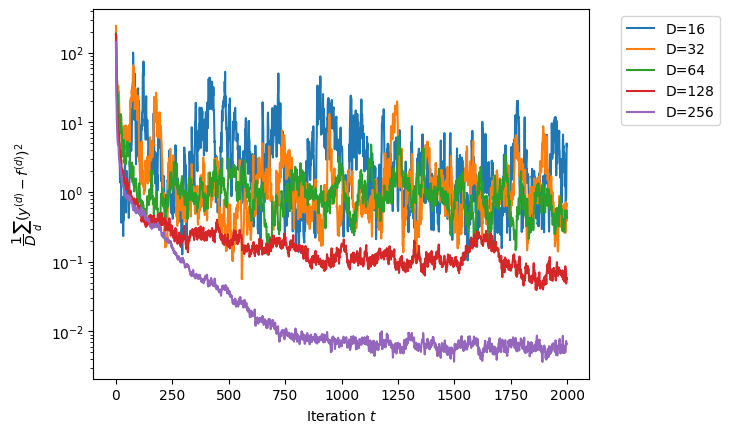

In [31]:
for i, D in enumerate(D_list):
    plt.plot(loss_hist_list[i], label=f'D={D}')
plt.yscale('log')
plt.xlabel(r'Iteration $t$')
plt.ylabel(r'$\dfrac{1}{D} \sum_{d} (y^{(d)} - f^{(d)})^2$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()